<a href="https://colab.research.google.com/github/yanezdavid/Predicting-Home-Prices/blob/main/Predicting_Home_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Investigative Question:** Can we predict the value of houses in Boston?

# Load Data

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#import libraries
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Explore & Clean Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Data/boston 3.csv')

In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


**Data dictionary** from [Kaggle](https://www.kaggle.com/c/2403-boston-housing-dataset/overview):
* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per $10,000

* PTRATIO: pupil-teacher ratio by town
* B: the proportion of black people by town
* LSTAT: % lower status of the population
* **MEDV: Median value of owner-occupied homes in $1000's [Target Variable]**




Check the number of rows and columns.

In [5]:
df.shape

(506, 14)

Confirm there are proper data types.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Check for missing values.

In [7]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Check for duplicated values.

In [8]:
df.duplicated().sum()

0

Check for correct values in categorical dummy columns.

In [9]:
df['CHAS'].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

In [10]:
df['RAD'].value_counts()

24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: RAD, dtype: int64

Use z scores to find & remove data points which are more than 4 z scores from the median. Outliers, high and low data points, are somewhat expected, but a z score of 4 or more will only remove the most extreme outliers.

In [12]:
from scipy import stats

z = np.abs(stats.zscore(df))

outlier_filter = (z < 4).all(axis=1)

df = df[outlier_filter]

In [13]:
df.shape

(499, 14)

The datapoints removed were alarmingly far from the mean for their respective column, as we can compare below, confirming that they were extreme outliers.

In [14]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,499.000000,499.000000,499.000000,499.00000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.00000,499.000000,499.000000
mean,2.848194,11.523046,11.039098,0.07014,0.553019,6.292900,68.179559,3.826611,9.346693,404.621242,18.431062,358.43990,12.498156,22.729259
std,5.317618,23.446576,6.858199,0.25564,0.115750,0.699509,28.138291,2.103304,8.596841,166.904173,2.170137,88.37619,7.001522,9.101339
min,0.006320,0.000000,0.460000,0.00000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.32000,1.730000,5.600000
25%,0.081005,0.000000,5.130000,0.00000,0.448500,5.888500,44.050000,2.111400,4.000000,279.000000,17.150000,375.95500,6.910000,17.200000
50%,0.249800,0.000000,8.560000,0.00000,0.538000,6.211000,76.700000,3.272100,5.000000,330.000000,19.000000,391.50000,11.280000,21.400000
75%,3.242325,12.500000,18.100000,0.00000,0.624000,6.627000,93.850000,5.214600,16.000000,666.000000,20.200000,396.22000,16.620000,25.000000
max,37.661900,100.000000,27.740000,1.00000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.90000,37.970000,50.000000


# EDA: Exploratory Data Analysis

Visualize correlations within the data.

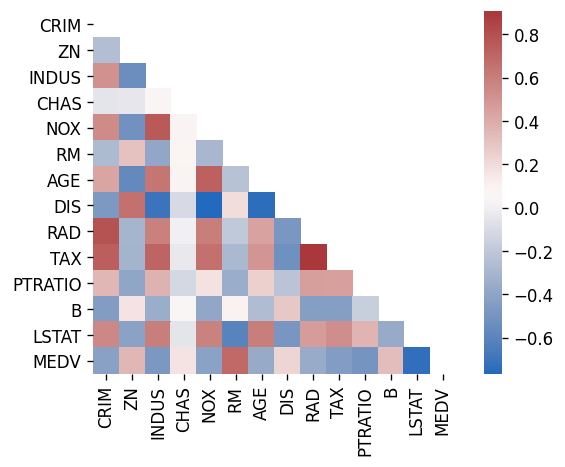

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            cmap='vlag',
            mask=mask,
            square=True);


There is signidicant multicollinearity in the dataset and the assumption of linearity is not met. Linear regression should be avoided as a predictive model.

There is a somewhat strong relationship between the median value of homes ($1,000s) & average number of rooms per home.

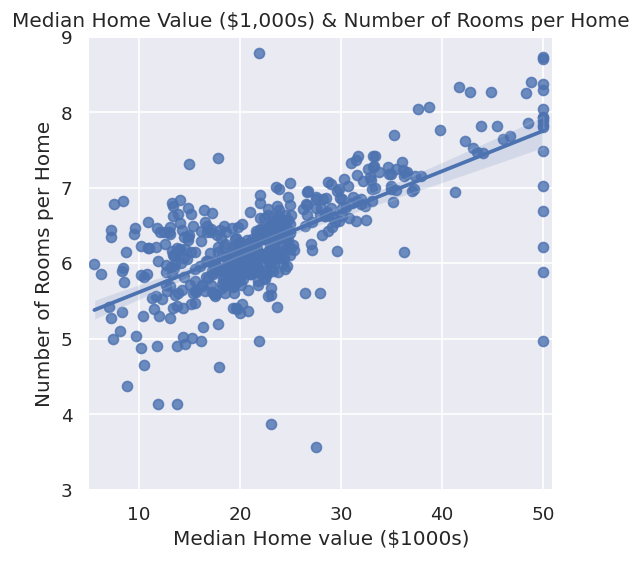

In [16]:
plt.figure(figsize=(5, 5));

sns.set(style="darkgrid");
sns.regplot(x=df['MEDV'],
            y=df['RM']);
plt.title('Median Home Value ($1,000s) & Number of Rooms per Home')

plt.xlim(5,51);
plt.xlabel('Median Home value ($1000s)');

plt.ylim(3,9);
plt.ylabel('Number of Rooms per Home');

There is a stronger negative relationship between median home value ($1,000s) & percentage of lower socioeconomic class in population.

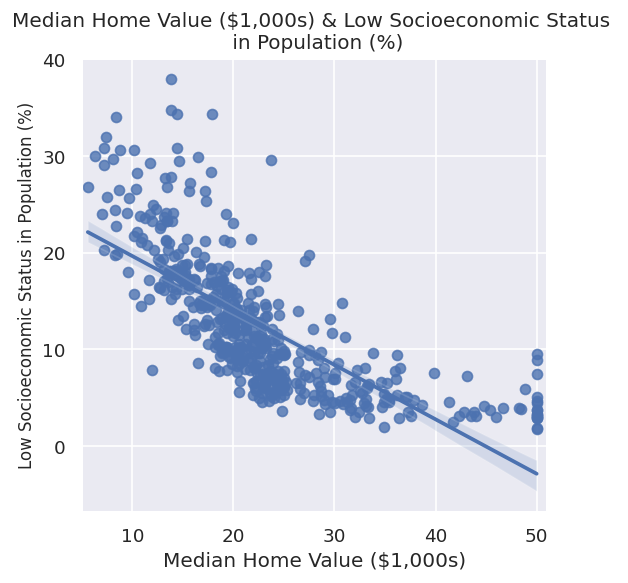

In [17]:
plt.figure(figsize=(5, 5));

sns.regplot(x=df['MEDV'],
            y=df['LSTAT']);
plt.title('Median Home Value ($1,000s) & Low Socioeconomic Status \n in Population (%)')

plt.xlabel('Median Home Value ($1,000s)', fontsize=12);
plt.xlim(5,51)

plt.ylabel('Low Socioeconomic Status in Population (%)', fontsize=10);

Let's visualize the distribution of our target variable: median price of home ($1,000s).

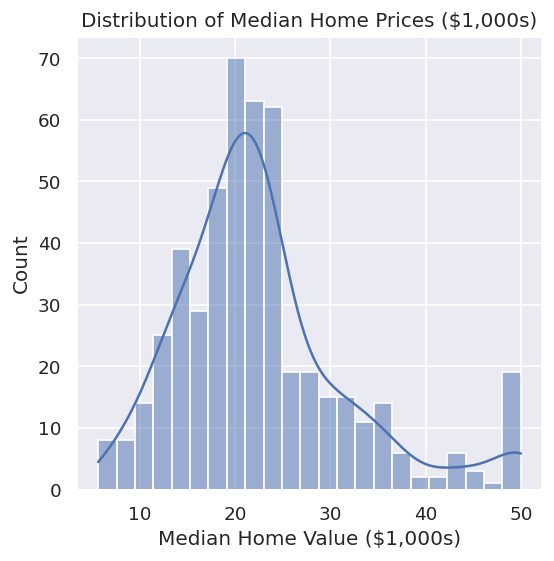

In [18]:
plt.figure(figsize=(5, 5));

sns.histplot(x=df['MEDV'],
             kde=True);

plt.xlabel('Median Home Value ($1,000s)')

plt.title('Distribution of Median Home Prices ($1,000s)');

Median home value ($1,000s) has a fairly normal-looking distribution.

Is there a mean difference in the price of homes located by a river vs. not located by a river?

In [19]:
df.groupby(['CHAS']).mean()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CHAS,,,,,,,,,,,,,
0,2.923363,11.810345,10.912371,0.549972,6.2758,67.476509,3.886722,9.349138,406.006466,18.501940,357.341810,12.592931,22.298491
1,1.851670,7.714286,12.719143,0.593426,6.5196,77.500000,3.029709,9.314286,386.257143,17.491429,372.997429,11.241714,28.440000


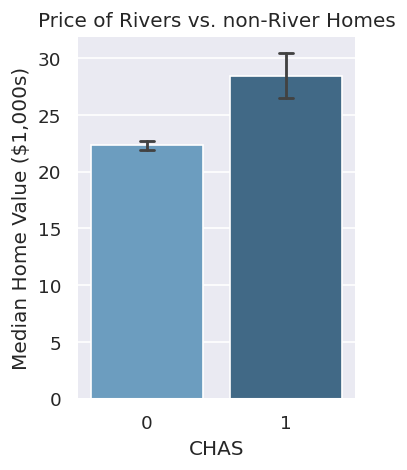

In [20]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

plt.figure(figsize=(3, 4));

sns.barplot(
    x='CHAS', 
    y='MEDV', 
    data=df, 
    ci=68, 
    color='#69b3a2',
    estimator=np.mean,
    capsize=.1,
    errwidth=1.7,
    palette="Blues_d",
    linewidth=1);

plt.title('Price of Rivers vs. non-River Homes');
plt.ylabel('Median Home Value ($1,000s)');

Visualize the distribution of median home value ($1,000s) grouped by highway accessibility rankings.

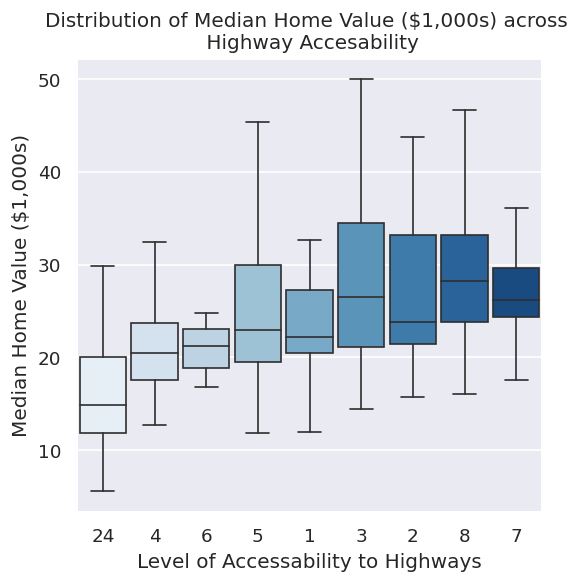

In [21]:
plt.figure(figsize=(5, 5));

sns.boxplot(x='RAD',
            y='MEDV',
            data=df,
            palette='Blues',
            order=(24, 4, 6, 5, 1, 3, 2, 8, 7),
            linewidth=1,
            width=.9,
            showfliers=False);

plt.ylabel('Median Home Value ($1,000s)');
plt.xlabel('Level of Accessability to Highways');
plt.title('Distribution of Median Home Value ($1,000s) across \n Highway Accesability');

Look at the mean differences between median home value ($1,000s) by highway accessability rankings

In [22]:
df.groupby(['RAD']).mean()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
RAD,,,,,,,,,,,,,
1,0.036029,39.900000,5.066000,0.050000,0.462890,6.555850,45.025000,6.027825,291.450000,17.565000,389.273000,7.370000,24.365000
2,0.083285,20.416667,9.630833,0.000000,0.484917,6.649958,64.770833,4.097008,260.666667,17.291667,386.413750,10.024583,26.833333
3,0.097359,16.381579,4.418947,0.052632,0.452424,6.473026,49.310526,5.146492,246.078947,18.168421,392.417895,9.076053,27.928947
4,0.393903,14.731818,10.746636,0.072727,0.504311,6.133118,60.841818,4.433000,335.981818,19.136364,382.721273,12.199091,21.387273
5,0.687792,11.108696,9.759826,0.095652,0.570883,6.393157,69.223478,3.697329,331.843478,16.546957,369.192435,10.657217,25.706957
6,0.150054,12.980769,8.198077,0.000000,0.514846,6.104731,60.142308,4.024915,372.884615,17.815385,387.366538,12.305769,20.976923
7,0.150399,26.705882,5.034706,0.000000,0.441000,6.647765,40.141176,6.495859,304.411765,18.405882,388.432941,7.988235,27.105882
8,0.371410,6.250000,5.932500,0.208333,0.492500,6.950792,67.350000,4.410604,301.250000,17.975000,385.277500,7.960833,30.358333
24,10.216259,0.000000,18.100000,0.064000,0.672320,6.040448,89.416000,2.090182,666.000000,20.200000,291.297760,18.315280,16.844800


# Supervised Machine Learning Predictions

# Random Forest Regressor

Split data into target vector and feature matrix.

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
X = df.drop(columns=['MEDV'])
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

In [24]:
from sklearn.metrics import mean_squared_error

No need to standardize the data for RandomForest models.

Instantiate and fit the model.

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Score baseline model.

In [26]:
print('train score: ' + str(rf_regressor.score(X_train, y_train)))
print('test score: ' + str(rf_regressor.score(X_test, y_test)))

train score: 0.9811089769159747
test score: 0.8812918348160584


Use GridSearchCV to find best hyperparameters and improve baseline model.

In [ ]:
rf_estimator = RandomForestRegressor()

rf_params = {'max_depth': ['sqrt', 'log2'],
             'n_estimators': range(50, 200, 25),
             'max_features': range(1, 20, 4)}

rf_grid_search = GridSearchCV(
    estimator=rf_estimator,
    param_grid=rf_params, 
    cv = 3,
    n_jobs = -1,
    verbose = 2,
    scoring='neg_mean_squared_error')

rf_grid_search.fit(X_train, y_train)

In [ ]:
rf_grid_search.best_params_

In [27]:
rf_regressor_opt = RandomForestRegressor(max_depth = 50,
                                         n_estimators = 175,
                                         min_samples_split = 2,
                                         max_features=1,
                                         random_state=42)

rf_regressor_opt.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=175, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [28]:
print('train score: ' + str(rf_regressor_opt.score(X_train, y_train)))
print('test score: ' + str(rf_regressor_opt.score(X_test, y_test)))

train score: 0.9717710332565729
test score: 0.8485924613880227


Default parameters are actually better fit for the model, thus we will use the default hyperparameters for the prediction.

In [29]:
rf_regressor.predict(X_test)

array([14.167, 24.364, 32.265, 26.527, 32.734, 21.171, 16.619, 33.497,
       22.152, 20.005, 19.974, 44.871, 22.315, 35.278, 26.294, 12.601,
       19.379, 14.131, 18.394, 19.683, 26.858, 24.043, 21.004, 23.32 ,
       25.569, 23.854, 39.834, 15.749, 22.4  , 19.535, 14.278, 21.882,
       15.437, 34.413, 21.989, 21.89 , 18.801, 33.852, 10.921, 22.801,
       47.202, 15.302, 15.096, 18.931, 26.969, 21.399, 23.913, 22.31 ,
       21.73 , 20.121, 21.601, 15.663, 15.243, 20.706, 18.844, 20.734,
       11.545, 23.283, 11.975, 20.429, 16.955, 27.391, 15.631, 48.026,
       23.761, 15.967, 26.753, 24.292, 15.208, 23.736, 20.705, 19.619,
       22.334, 22.056, 19.861, 24.663, 20.169, 21.426, 23.134, 17.455,
       23.62 , 17.921, 19.68 , 21.521, 23.547, 19.535, 23.797,  9.546,
       16.236, 46.396, 18.982, 20.856, 23.492, 10.202, 20.005, 21.394,
        9.628, 19.377, 23.799, 19.482, 23.08 , 31.214, 46.6  , 19.571,
       28.544, 15.467, 11.533, 11.788, 16.289, 28.814, 42.925, 14.353,
      

In [30]:
predicted = rf_regressor.predict(X_test)
actual = y_test

mean_squared_error(predicted, actual)

8.371543819999998

# XGBoost Regression

Create and score baseline model.

In [31]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

XGB = XGBRegressor(random_state=42)
XGB.fit(X_train, y_train)

print('train score: ' + str(XGB.score(X_train, y_train)))
print('test score: ' + str(XGB.score(X_test, y_test)))

[08:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train score: 0.9788019608017949
test score: 0.8807508876272794


Run GridSearchCV to find optimal hyperparameters.

In [32]:
xgb_estimator = XGBRegressor(
    objective= 'reg:linear',
    nthread=4,
    random_state=42)

xgb_params = {'learning_rate': [.001, .01, .1, .3, .5, .8],
          'max_depth': [1, 2, 3, 4, 5, 6],
          'max_features': [1, 2, 3, 4, 5, 6],
          'n_estimators': [20, 50, 80, 110, 140]}

xgb_grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=xgb_params,
    scoring = 'neg_mean_squared_error',
    n_jobs = 5,
    cv = 5,
    verbose=True)

xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
xgb_grid_search.best_params_

Implement optimized model with best hyperparameters.

In [33]:
XGB_opt = XGBRegressor(learning_rate= 0.3,
                        max_depth = 6,
                        max_features = 1,
                        n_estimators = 50)

XGB_opt.fit(X_train, y_train)

[08:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=6, max_features=1, min_child_weight=1, missing=None,
             n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [34]:
print('train score: ' + str(XGB_opt.score(X_train, y_train)))
print('test score: ' + str(XGB_opt.score(X_test, y_test)))

train score: 0.9998778495788055
test score: 0.8862491440563249


Predict values using optimized model.

In [35]:
XGB_opt.predict(X_test)

array([15.492055 , 24.20718  , 35.53616  , 30.707619 , 36.18985  ,
       20.454319 , 15.17233  , 36.61222  , 22.8423   , 18.329315 ,
       19.848732 , 42.906506 , 22.235706 , 37.716248 , 27.162416 ,
       11.228921 , 19.168169 , 13.933767 , 17.883318 , 19.075481 ,
       24.925411 , 23.54472  , 20.056747 , 20.716946 , 26.48555  ,
       23.433159 , 44.9284   , 14.53645  , 20.644659 , 20.168352 ,
       13.873834 , 21.127367 , 13.706489 , 35.609818 , 21.02564  ,
       19.688751 , 18.21509  , 38.52404  , 12.530326 , 22.516115 ,
       49.66799  , 15.9668255, 14.663615 , 19.152103 , 27.060848 ,
       23.19652  , 26.037533 , 23.235966 , 20.581676 , 22.852654 ,
       22.59716  , 16.386951 , 15.221071 , 18.60701  , 18.098913 ,
       21.455488 , 10.273667 , 20.068054 , 12.878628 , 21.36158  ,
       15.855267 , 29.12712  , 15.8733835, 49.55685  , 22.656721 ,
       15.786916 , 27.922829 , 24.066334 , 16.707184 , 24.213434 ,
       21.047123 , 19.490385 , 23.327003 , 22.275126 , 19.6833

In [36]:
predicted = XGB_opt.predict(X_test)
actual = y_test

mean_squared_error(predicted, actual)

8.021944182351852

# KNeighborsRegressor

Standardize data.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.27031463, -0.49252174,  0.9960523 , ...,  0.83495444,
        -0.36374879,  1.26084469],
       [-0.53100739, -0.49252174, -0.05761126, ...,  0.38547257,
         0.18828155, -0.69866382],
       [-0.48028222, -0.49252174, -0.72391976, ..., -0.42359481,
         0.17588854, -1.02430058],
       ...,
       [-0.54310431, -0.49252174, -0.17323963, ..., -0.24380206,
         0.38235847, -0.05876627],
       [-0.53555156, -0.49252174, -0.62129958, ..., -0.19885387,
         0.42567385, -0.31899127],
       [-0.36824777, -0.49252174, -0.44352096, ...,  1.19453995,
         0.30475177, -0.8351753 ]])

Create, fit, and score baseline model.

In [39]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor()
KNN.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [40]:
print('train score: ' + str(KNN.score(X_train, y_train)))
print('test score: ' + str(KNN.score(X_test, y_test)))

train score: 0.6818520835065311
test score: 0.5526800457224965


Use GridSearchCV to find optimal hyperparameters.

In [41]:
KNN_opt = KNeighborsRegressor()
KNN_params = {'n_neighbors': [5, 10, 20, 40, 80, 160, 250],
         'leaf_size': range(1,50,5,),
         'weights': ['uniform','distance'],
         'leaf_size': [1,5,10,20,40]
}

KNN_grid_search = GridSearchCV(KNN_opt,
                               param_grid = KNN_params,
                               cv = 5,
                               verbose=1)

KNN_grid_search.fit(X_train, y_train)

KNN_grid_search.best_params_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    2.2s finished


{'leaf_size': 1, 'n_neighbors': 10, 'weights': 'distance'}

In [42]:
KNN_opt = KNeighborsRegressor(leaf_size = 1,
                              n_neighbors = 6,
                              weights = 'distance',
                              )

KNN_opt.fit(X_train, y_train)

print('train score: ' + str(KNN_opt.score(X_train, y_train)))
print('test score: ' + str(KNN_opt.score(X_test, y_test)))

train score: 1.0
test score: 0.5484453612384825


Like the RandomForestRegression, the default hyperparemeters performed better than the GridSearchCV.

In [43]:
KNN.predict(X_test)

array([14.22, 27.94, 35.46, 24.3 , 32.44, 12.98, 16.98, 37.54, 23.84,
       20.22, 19.68, 40.02, 32.84, 32.84, 22.02, 12.32, 21.36, 17.56,
       17.86, 21.58, 40.02, 24.36, 21.56, 28.78, 25.3 , 23.34, 19.22,
       14.6 , 23.6 , 22.4 , 17.38, 32.62, 16.06, 21.66, 23.54, 22.92,
       23.32, 29.22, 12.34, 24.72, 34.52, 17.38, 17.56, 20.58, 21.56,
       22.44, 23.06, 24.54, 21.82, 28.34, 30.22, 12.62, 20.84, 18.74,
       16.26, 24.66, 16.8 , 21.08, 11.66, 23.32,  9.46, 34.52, 13.46,
       41.96, 24.84, 21.12, 32.84, 28.78, 14.5 , 22.44, 22.02, 17.86,
       24.84, 22.88, 21.56, 28.72, 20.14, 23.6 , 25.3 , 20.78, 24.38,
       15.46, 17.48, 22.28, 27.62, 21.18, 20.22, 10.74, 20.3 , 29.72,
       20.62, 21.82, 21.96, 14.84, 21.96, 18.94, 10.68, 21.74, 23.44,
       22.8 , 26.3 , 31.32, 31.86, 23.6 , 26.54, 12.52, 12.52, 12.62,
       17.2 , 27.4 , 32.38, 13.28, 21.6 , 24.16, 22.96, 24.26, 26.08,
       21.38, 29.34, 21.24, 11.16, 12.32, 23.7 , 21.02, 24.56, 20.28,
       17.56, 17.4 ,

In [44]:
predicted = KNN.predict(X_test)
actual = y_test

mean_squared_error(predicted, actual)

31.545922666666666

# Unsupervised Clustering


KMeans Clustering.

In [45]:
from sklearn.cluster import KMeans

scaler.fit_transform(df)

kmeans = KMeans(n_clusters = 2)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

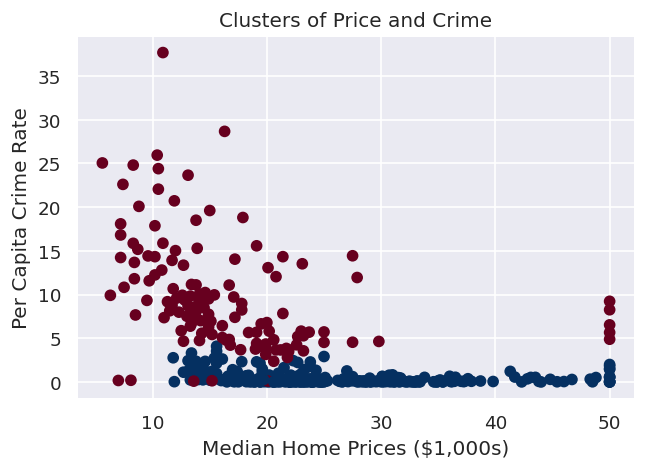

In [46]:
df['cluster'] = kmeans.labels_
plt.scatter(df['MEDV'], df['CRIM'], c = df['cluster'], cmap='RdBu')
plt.xlabel('Median Home Prices ($1,000s)')
plt.ylabel('Per Capita Crime Rate')
plt.title('Clusters of Price and Crime');

In [47]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

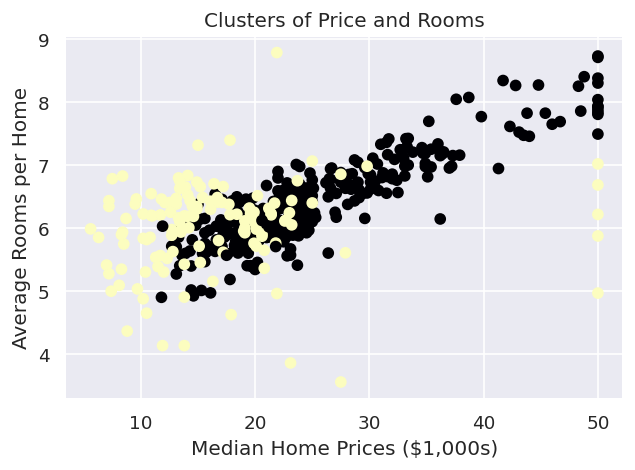

In [48]:
df['cluster'] = kmeans.labels_
plt.scatter(df['MEDV'], df['RM'], c = df['cluster'], cmap='magma')
plt.xlabel('Median Home Prices ($1,000s)')
plt.ylabel('Average Rooms per Home')
plt.title('Clusters of Price and Rooms');